### Media Sharing Index (MSI)

MSI is based on the media outlets shared by each user, therefore this index reflects the group of media an user shares.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import matplotlib 

np.random.seed(123458)

In [2]:
# Data with only columns of interest
data = pd.read_csv('../Data/data.csv', usecols=['tid', 'uid', 'dynamic_opinion', 'url', 'outlet'])
data.head(n = 5)

,url,outlet,dynamic_opinion,tid,uid
0,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,3123001870860070177,-5290478328161710131
1,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1161354566247419187,1984147057615254567
2,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,-8265852459726288982,907971274336289915
3,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,2424256138563082008,-1315437987437732754
4,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,-8244136094798448801,6507777798650809238


### Encoding matrix user - media share
User - media shares dataframe based on one-hot encoding of media shares

In [3]:
user_media_df = pd.DataFrame()

# user_id column
user_media_df['uid'] = data['uid']

#creating instance of one-hot-encoder and one-hot encoding of media shares
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data[['outlet']]).toarray())
encoder_df.columns = list(encoder.categories_[0])

user_media_df = user_media_df.join(encoder_df)

In [4]:
user_media_df = user_media_df.groupby('uid').sum()
user_media_df.head(n = 5)

,Ambito Financiero,Clarin,Contexto,El Cronista,El Destape,El Dia,El Litoral,Infobae,Jornada,La Izquierda Diario,La Nacion,Minuto Uno,Pagina 12,Perfil,Radio Dos,Radio Mitre,Todo Noticias
uid,,,,,,,,,,,,,,,,,
-9223322503111527589,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9222975002879431468,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
-9222847178814893203,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
-9222742428357238434,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
-9222729263223077870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We calculate the MSI over a subset of main media outlets:

In [5]:
# principal media outlets to include in the calculation of the MSI
ppal_media = ['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae', 'El Destape']
ppal_media += ['Ambito Financiero', 'Minuto Uno', 'Perfil', 'El Cronista', 'Radio Mitre', 'El Dia']

user_media_df_filtered = user_media_df[ppal_media].copy()

# Users that share at least two media outlets
user_media_df_filtered = user_media_df_filtered[user_media_df_filtered.apply(np.count_nonzero, axis = 1) > 1].copy()

In [6]:
user_media_df_filtered.columns

Index(['Clarin', 'La Nacion', 'Pagina 12', 'Todo Noticias', 'Infobae',
       'El Destape', 'Ambito Financiero', 'Minuto Uno', 'Perfil',
       'El Cronista', 'Radio Mitre', 'El Dia'],
      dtype='object')

In [7]:
# Matrix of user - media shared
A = user_media_df_filtered.to_numpy()
print(A.shape)

(49183, 12)


MSI calculated as proposed in *Lowe, W. (2008). Understanding wordscores. Political Analysis, 16(4), 356-371.*, based in weighted averages, which yields the same results as applying Correspondence Analysis:

In [8]:
# initial values
score_users = np.random.normal(loc = 0, scale = 1.00, size = A.shape[0])
score_users = (score_users - np.mean(score_users))/np.std(score_users)

# iteration until convergence
for iteration in range(50):
    
    score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])
    score_users = np.array([np.average(score_media, weights=A[j,:]) for j in range(A.shape[0])])

    score_users = (score_users - np.mean(score_users))/np.std(score_users)

# final calculation of the score of media outlets
score_media = np.array([np.average(score_users, weights=A[:,i]) for i in range(A.shape[1])])

Save of the data:

In [9]:
msi_users = pd.DataFrame()
msi_users['uid'] = user_media_df_filtered.index
msi_users['msi'] = score_users

### MSI calculated by correspondence analysis

Correspondence analysis function:

In [10]:
def calculate_scores(A):
    
    P = (1/np.sum(A))*A # Nomalized matrix

    # Defining needings for standardizing
    n_col = np.shape(P)[1]
    n_row = np.shape(P)[0]
    r = np.matmul(P, np.ones((n_col,))) #rows
    c = np.matmul(np.ones((n_row,)), P) #columns
    r2 = r**(-0.5)
    c2 = c**(-0.5)
    Dr2 = np.diag(r2)
    Dc2 = np.diag(c2)
    r_t = np.array([r]).transpose()
    c_new = np.array([c])

    #Standardized residuals
    S = np.matmul(np.matmul(Dr2, P - np.matmul(r_t,c_new)),Dc2)
    
    #FULL SVD
    U, sig, Vt = np.linalg.svd(S, full_matrices=False)

    #scores
    X_dim1 = np.matmul(Dr2,U)[:,0] #scores matrix
    scores = (-1 + 2 * (X_dim1-np.min(X_dim1))/np.ptp(X_dim1)) #scaled
    
    return scores

In [11]:
# Aplication of the algorithm
score_users_by_svd = calculate_scores(A)

#### Comparison

In [12]:
# Append score calculated by svd 
msi_users['score_by_svd'] = score_users_by_svd

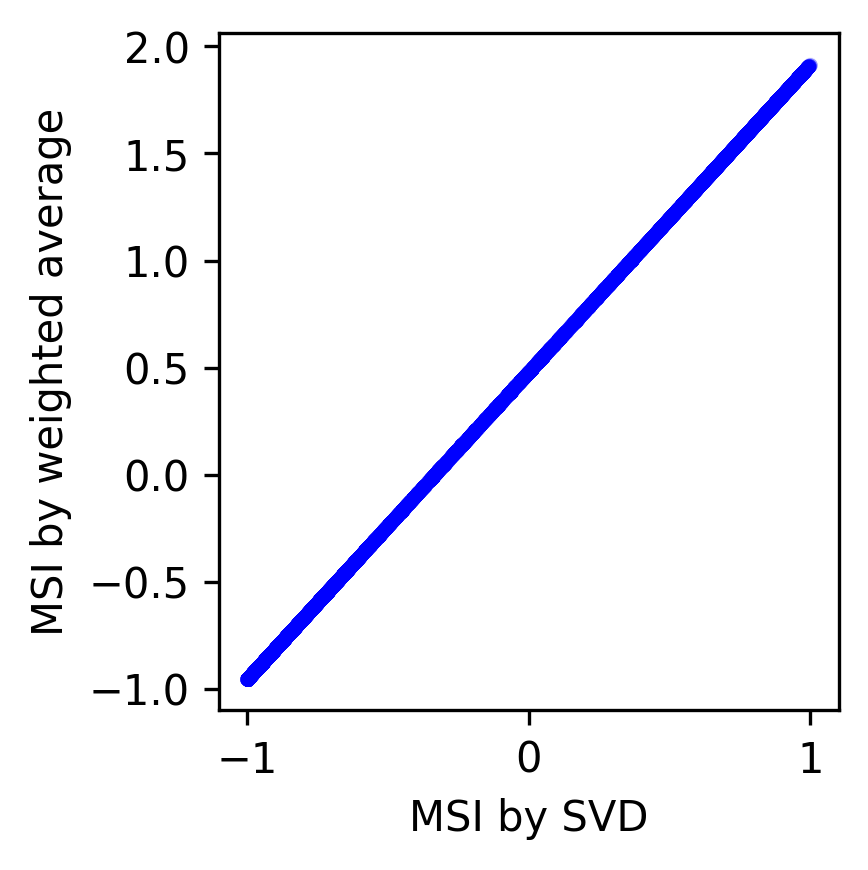

In [24]:
plt.figure(dpi = 300, figsize=(3,3))
plt.plot(msi_users['score_by_svd'], msi_users['msi'], marker = '.', alpha = 0.05, markersize = 5, color = 'b')
plt.xlabel('MSI by SVD', size = 10)
plt.ylabel('MSI by weighted average', size = 10)
plt.tight_layout()
plt.show()

In [22]:
# Spearman correlation
msi_users[['msi','score_by_svd']].corr('spearman')

,msi,score_by_svd
msi,1.000000,0.999996
score_by_svd,0.999996,1.000000
